In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from time import time
from fastdtw import fastdtw
from functions import utils
from functions import utils_dtw
import os.path as path
from multiprocessing import Pool
import multiprocessing

sample_file = utils.gui_fname().decode("utf-8")
# background_filename = utils.gui_fname().decode("utf-8")
tokens = sample_file.split('/')
base = path.basename(sample_file)
abs_dir = path.dirname(sample_file)
prefix = base.split('.')[0]
sample_prefix = abs_dir + '/' + prefix
print("Sample: \n%s" %sample_file)

init_class = np.zeros((3, 200))
n_classes = 0

Sample: 
/Users/ashleefeng/OneDrive - Johns Hopkins/PacBio/pacbio_example/30s_43N43_Cy3-DNA_Cy5-H2A/m181207_211324_42131_c000468682559900001500000112312060_s1_p0.upd.h5


## Utility functions

In [2]:
def plot_traces(n, data, indices):
    plt.figure(figsize=(15, n*1.2))
    if n % 2 == 1:
        n = n-1
    for i in range(n):
        plt.subplot(int(n/2), 2, i+1)
        trc = data[indices[i]]
        if len(data.shape) == 2:
            plt.plot(time_axis, trc)
        else:
            for j in range(data.shape[1]):
                plt.plot(time_axis, trc[j], color=colors[j])

        plt.xlabel('Time (s)')
        plt.ylabel('Intensity')
        plt.title('Trace ' + str(i))
        
        i = i + 1
    plt.subplots_adjust(hspace=0.7)

def dtw(a1, a2):
    return fastdtw(a1.T, a2.T)[0]

def dtw_classification(data, n_classes, n_frames, rep_trc_IDs):
    start = time()

    init_class = np.zeros((n_classes, n_frames))
    
    for i in range(n_classes):
        init_class[i] = scaled_data_cy5[rep_trc_IDs[i]]

    labels = []
    for i in range(len(data)):
        trc = data[i]
        min_dist = 1e9
        curr_label = 0
        for j in range(n_classes):
            dist = dtw(trc, init_class[j])
            if dist < min_dist:
                min_dist = dist
                curr_label = j
        labels.append(curr_label)

    print("Time passed: " + str(time() - start))
    return labels

def dtw_single(m):
    
    trc = scaled_data_cy5[m]
    min_dist = 1e9
    curr_label = 0
    for j in range(n_classes):
        dist = dtw(trc, init_class[j])
        if dist < min_dist:
            min_dist = dist
            curr_label = j
    return curr_label

def dtw_classification_parallel(n_classes_curr, n_frames, rep_trc_IDs):

    start = time()
    
    global init_class
    global n_classes
    n_classes = n_classes_curr
    
    for i in range(n_classes):
        init_class[i] = scaled_data_cy5[rep_trc_IDs[i]]
        
    labels = []
    pool = multiprocessing.Pool(multiprocessing.cpu_count())
    labels = pool.map(dtw_single, iter(range(len(scaled_data_cy5))))

    print("Time passed: " + str(time() - start))
    return labels

def class_extractor(labels, n_classes):
    cls_members = {}
    for i in range(len(labels)):
        cls = labels[i]
        if cls in cls_members.keys():
            cls_members[cls].append(i)
        else:
            cls_members[cls] = [i]
    return cls_members

## Load data

In [3]:
trc_filename = sample_prefix + '.trc.h5'
mcd_filename = sample_prefix + '.mcd.h5'
upd_filename = sample_prefix + '.upd.h5'
meta_filename = sample_prefix + '.metadata.xml'

trc_file = h5py.File(trc_filename, 'r')
mcd_file = h5py.File(mcd_filename, 'r')
upd_file = h5py.File(upd_filename, 'r')

# Load data in trace file
dset = trc_file['TraceData']
raw_traces = dset['Traces']
decode = dset['Codec']['Decode']
n_traces = raw_traces.shape[0]
n_frames = raw_traces.shape[2]
decode_array = np.array(decode)

# Load data in upd file
upd_TD = upd_file['TraceData']
hole_xy_plot = upd_TD['HoleXYPlot'] # (x,y) coordinates for each well
hole_status = upd_TD['HoleStatus'] # fiducials

# Extract frame rate from metadata
meta_tree = ET.parse(meta_filename)
root = meta_tree.getroot()
for keyval in root.iter('{http://pacificbiosciences.com/PAP/Metadata.xsd}KeyValue'):
    if keyval.attrib['key'] == 'MovieFPS':
        fps = int(keyval.text)
        frame_rate = 1.0/fps # seconds
        break

# For plotting
time_axis = np.arange(n_frames)*frame_rate
colors = ['green', (0, 1, 0), 'red', 'orange']
lasers = ['Cy3', 'Cy3.5', 'Cy5', 'Cy5.5']

In [4]:
# Skip decode
traces = raw_traces

In [5]:
avg_intens = np.mean(traces, axis=2)
# zero-center the traces
centered_traces = np.zeros(raw_traces.shape)
for i in range(n_traces):
    for j in range(4):
        centered_traces[i, j] = traces[i, j] - avg_intens[i, j]

# Compute cross-correlation
corr_list = np.zeros(n_traces)
for i in range(n_traces):
    cy3 = centered_traces[i][0]
    cy5 = centered_traces[i][2]
    corr_list[i] = np.correlate(cy3, cy5)

sorting_index = np.argsort(corr_list)

In [6]:
scaled_data_cy5 = np.zeros((n_traces, n_frames))

for i in range(n_traces):
    cy5_trc = centered_traces[i, 2, :]
    cy5_min = cy5_trc.min()
    cy5_max = cy5_trc.max()
    if cy5_min == cy5_max:
        scaled_data_cy5[i] = np.ones(cy5_trc.shape)
    else:
        scaled_data_cy5[i] = (cy5_trc - cy5_min) / (cy5_max - cy5_min)

In [7]:
labels_p = dtw_classification_parallel(3, n_frames, [sorting_index[1], 64050, 33104])

Time passed: 18.54392409324646


In [8]:
sorting_index[1]

160027

(array([  5713.,      0.,      0.,      0.,      0., 154666.,      0.,
             0.,      0.,   3103.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

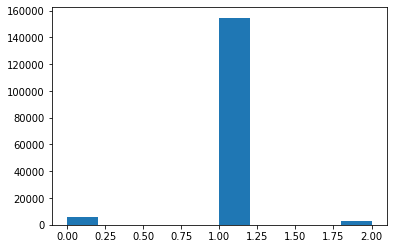

In [9]:
plt.hist(labels_p)

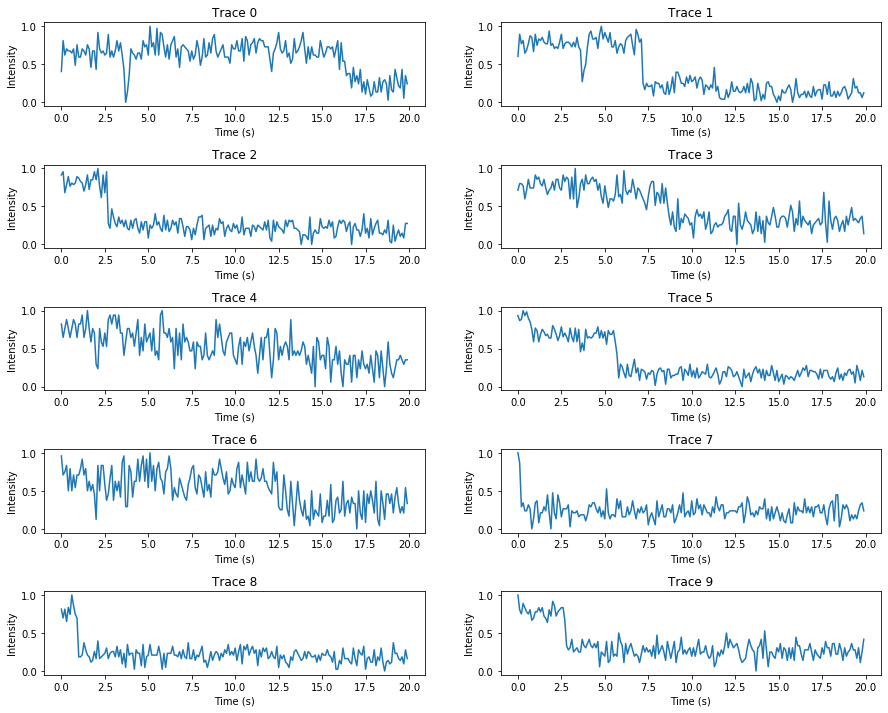

In [10]:
classes = class_extractor(labels_p, 4)
plot_traces(10, scaled_data_cy5, np.random.choice(classes[0], size=(10,)))

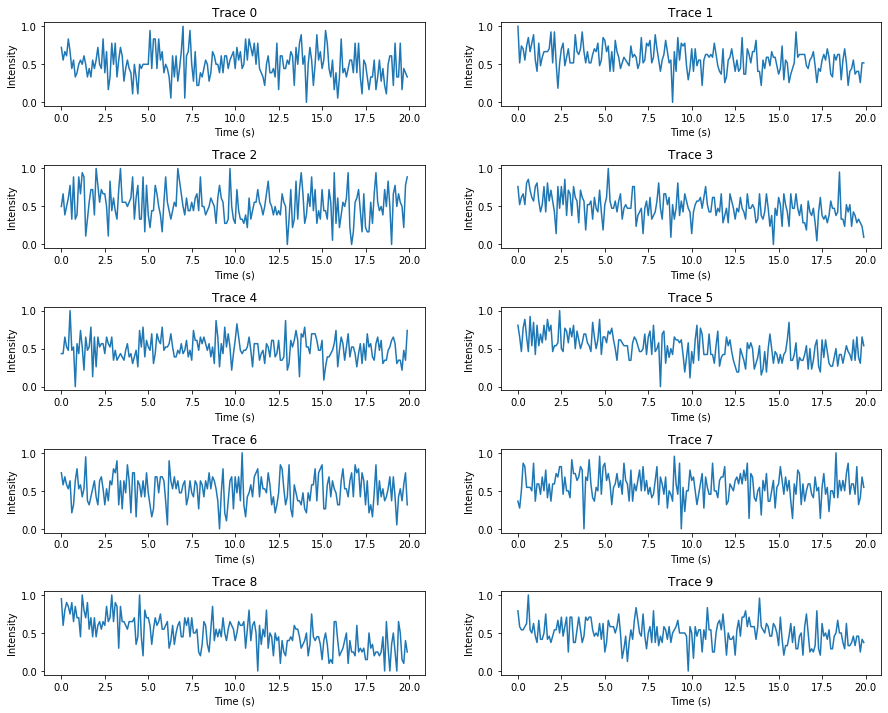

In [11]:
plot_traces(10, scaled_data_cy5, np.random.choice(classes[1], size=(10,)))

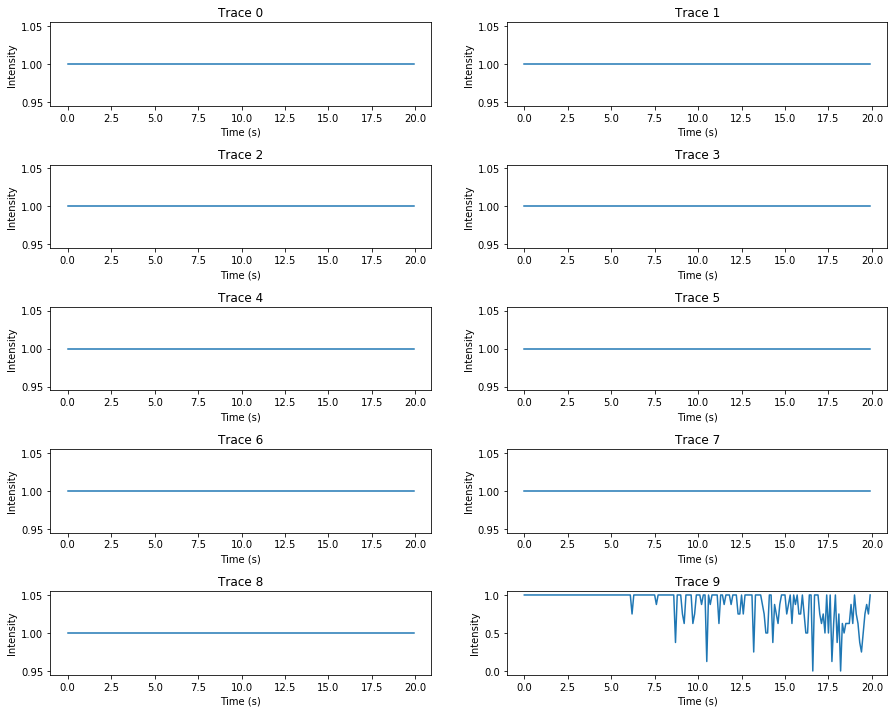

In [12]:
plot_traces(10, scaled_data_cy5, np.random.choice(classes[2], size=(10,)))